In [ ]:
import os
from collections import defaultdict
import re
import pandas as pd
import json
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import open_clip
from open_clip import create_model_from_pretrained, get_tokenizer
from PIL import Image
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image


base_path = '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/largeListsGuy'

# Load your data
with open(base_path + "/retrieval_labeled_img_pairs.pkl", "rb") as f:
    labeled_img_pairs = pickle.load(f)

def extract_uid(img_path):
    """
    Extracts the uid from the image path.
    Assumes that the uid is the last directory before the image filename.
    """
    # Split the path into parts
    path_parts = os.path.normpath(img_path).split(os.sep)
    # Get the uid (second last part)
    uid = path_parts[-2]
    return uid

def dfs(uid, visited, component):
    visited.add(uid)
    component.add(uid)
    for neighbor in uid_graph[uid]:
        if neighbor not in visited:
            dfs(neighbor, visited, component)

# Build the uid_graph
uid_graph = defaultdict(set)

# Build the graph
for (img_path1, img_path2), label in labeled_img_pairs:
    uid1 = extract_uid(img_path1)
    uid2 = extract_uid(img_path2)
    uid_graph[uid1].add(uid2)
    uid_graph[uid2].add(uid1)

# Find connected components
visited = set()
components = []

for uid in uid_graph:
    if uid not in visited:
        component = set()
        dfs(uid, visited, component)
        components.append(component)

# Step 1: Build UID to component index mapping
uid_to_component_idx = {}

for idx, component in enumerate(components):
    for uid in component:
        uid_to_component_idx[uid] = idx

# Step 2: Count samples per component
component_sample_counts = [0] * len(components)

for (img_path1, img_path2), label in labeled_img_pairs:
    uid1 = extract_uid(img_path1)
    component_idx = uid_to_component_idx[uid1]
    component_sample_counts[component_idx] += 1

# Step 3: Sort components by sample count
components_with_counts = list(zip(components, component_sample_counts))
components_with_counts.sort(key=lambda x: x[1], reverse=True)

# Step 4: Assign components to training and test sets
total_samples = len(labeled_img_pairs)
desired_train_samples = int(total_samples * 0.8)

train_uids = set()
test_uids = set()

accumulated_train_samples = 0

for component, sample_count in components_with_counts:
    if accumulated_train_samples < desired_train_samples:
        train_uids.update(component)
        accumulated_train_samples += sample_count
    else:
        test_uids.update(component)

# Step 5: Assign samples to training and test sets, discard cross-set samples
train_data = []
test_data = []
discarded_samples = []

for sample in labeled_img_pairs:
    (img_path1, img_path2), label = sample
    uid1 = extract_uid(img_path1)
    uid2 = extract_uid(img_path2)

    if uid1 in train_uids and uid2 in train_uids:
        train_data.append(sample)
    elif uid1 in test_uids and uid2 in test_uids:
        test_data.append(sample)
    else:
        # Discard cross-set samples to maintain UID exclusivity
        discarded_samples.append(sample)

# Step 6: Verify the split ratio
train_sample_count = len(train_data)
test_sample_count = len(test_data)
total_sample_count = train_sample_count + test_sample_count

train_ratio = train_sample_count / total_sample_count
test_ratio = test_sample_count / total_sample_count

print(f"Training samples: {train_sample_count} ({train_ratio:.2%})")
print(f"Test samples: {test_sample_count} ({test_ratio:.2%})")
print(f"Discarded samples: {len(discarded_samples)}")

# Step 7: Ensure UID exclusivity in the test set
uids_in_training_samples = set()
for (img_path1, img_path2), label in train_data:
    uids_in_training_samples.update([extract_uid(img_path1), extract_uid(img_path2)])

uids_in_test_samples = set()
for (img_path1, img_path2), label in test_data:
    uids_in_test_samples.update([extract_uid(img_path1), extract_uid(img_path2)])

overlap_uids = uids_in_test_samples.intersection(uids_in_training_samples)
assert len(overlap_uids) == 0, "Overlap detected between training and test UIDs!"

print("UID exclusivity between training and test sets is maintained.")

counter = 0
for (img_pair, label) in labeled_img_pairs:
    if label == 1:
        counter += 1
print(f"Total Positive Pairs {counter}")


counter = 0
for (img_pair, label) in train_data:
    if label == 1:
        counter += 1
print(f"Training Positive Pairs {counter}")

counter = 0
for (img_pair, label) in train_data:
    if label == 0:
        counter += 1
print(f"Training Negative Pairs (before the hard visual negatives) {counter}")

counter = 0
for (img_pair, label) in test_data:
    if label == 1:
        counter += 1
print(f"Test Positive Pairs {counter}")

# Load additional negative pairs
with open(base_path + "/visual_labeled_img_negative_pairs.pkl", "rb") as f:
    visual_labeled_img_negative_pairs = pickle.load(f)

train_data.extend(visual_labeled_img_negative_pairs)
counter = 0
for (img_pair, label) in train_data:
    if label == 0:
        counter += 1
print(f"Training Negative Pairs (after the hard visual negatives) {counter}")


# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Training samples: 1056 (79.94%)
Test samples: 265 (20.06%)
Discarded samples: 0
UID exclusivity between training and test sets is maintained.
Total Positive Pairs 1321
Training Positive Pairs 1056
Training Negative Pairs (before the hard visual negatives) 0
Test Positive Pairs 265
Training Negative Pairs (after the hard visual negatives) 1727


In [14]:
with open(base_path + "/diagrams_compound_filtered_paths_list.json", 'r') as f:
    candidate_paths_list = json.load(f)

In [15]:
len(candidate_paths_list)

119204

In [2]:
# CandidateImageDataset in order to calculate efficiently visual embeddings for Retrieval Metrics
class CandidateImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return img_path, image

# QueryImageDataset in order to calculate efficiently visual embeddings for Retrieval Metrics
class QueryImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return img_path, image

class TestImagePairDataset(Dataset):
    def __init__(self, pairs_list, transform=None):
        self.pairs_list = pairs_list
        self.transform = transform

    def __len__(self):
        return len(self.pairs_list)

    def __getitem__(self, idx):
        (img_path1, img_path2), label = self.pairs_list[idx]
        img1 = Image.open(img_path1).convert('RGB')
        img2 = Image.open(img_path2).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.tensor(label, dtype=torch.float32)
        return (img1, img2), label

class TrainImagePairDataset(Dataset):
    def __init__(self, pairs_list, transform=None):
        self.pairs_list = pairs_list
        self.transform = transform

    def __len__(self):
        return len(self.pairs_list)

    def __getitem__(self, idx):
        (img_path1, img_path2), label = self.pairs_list[idx]
        img1 = Image.open(img_path1).convert('RGB')
        img2 = Image.open(img_path2).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        label = torch.tensor(label, dtype=torch.float32)
        return (img1, img2), label

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class ImageEmbeddingModel(nn.Module):
    def __init__(self, model):
        super(ImageEmbeddingModel, self).__init__()
        self.model = model 

    def forward(self, x):
        embeddings = self.model.encode_image(x)
        embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings
        return embeddings

# Function to initialize the model
def initialize_biomedclip_model():
    biomedclip_model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
    biomedclip_model.to(device)
    tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
    return biomedclip_model, preprocess, tokenizer

# Circle Loss
class CircleLoss(nn.Module):
    def __init__(self, margin=0.25, gamma=80):
        super(CircleLoss, self).__init__()
        self.margin = margin
        self.gamma = gamma
        self.soft_plus = nn.Softplus()

    def forward(self, sp, sn):
        ap = torch.clamp_min(-sp.detach() + 1 + self.margin, min=0.)
        an = torch.clamp_min(sn.detach() + self.margin, min=0.)
        delta_p = 1 - self.margin
        delta_n = self.margin

        logit_p = - self.gamma * ap * (sp - delta_p)
        logit_n = self.gamma * an * (sn - delta_n)

        loss = self.soft_plus(torch.logsumexp(logit_n, dim=0) + torch.logsumexp(logit_p, dim=0))
        return loss

# Set hyperparameters
margin = 0.3
gamma_loss = 60
learning_rate = 3e-7
num_epochs = 7
optimizer_name = 'Adam'
batch_size = 16
weight_decay = 1e-4

# Initialize the model
biomedclip_model, preprocess, _ = initialize_biomedclip_model()

# Initialize the image embedding model
image_embedding_model = ImageEmbeddingModel(biomedclip_model).to(device)

# Ensure all parameters are trainable
for param in image_embedding_model.parameters():
    param.requires_grad = True

# Dataloader for training set
train_dataset = TrainImagePairDataset(train_data, transform=preprocess)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Dataloader for test set
test_dataset = TestImagePairDataset(test_data, transform=preprocess)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the criterion and optimizer
criterion = CircleLoss(margin=margin, gamma=gamma_loss)

# Initialize optimizer
optimizer = torch.optim.Adam(image_embedding_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training and Validation Loop
for epoch in range(num_epochs):
    image_embedding_model.train()
    train_loss = 0

    for (img1, img2), labels in train_dataloader:
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        embeddings1 = image_embedding_model(img1)
        embeddings2 = image_embedding_model(img2)

        # Prepare similarities for CircleLoss
        cos_sim = F.cosine_similarity(embeddings1, embeddings2)
        pos_mask = labels == 1
        neg_mask = labels == 0
        sp = cos_sim[pos_mask]
        sn = cos_sim[neg_mask]
        if sp.numel() > 0 and sn.numel() > 0:
            loss = criterion(sp, sn)
        else:
            continue  # Skip if no positive or negative pairs in batch

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.6f}')

    # Validation loop
    # # Collect all unique image paths from test_data
    # candidate_paths_set = set()
    # for (img_path1, img_path2), _ in test_data:
    #     candidate_paths_set.update([img_path1, img_path2])

    # for (img_path1, img_path2), _ in train_data:
    #     candidate_paths_set.update([img_path1, img_path2])

    # candidate_paths_list = list(candidate_paths_set)

    # Prepare candidate dataset and dataloader
    candidate_dataset = CandidateImageDataset(candidate_paths_list, transform=preprocess)
    candidate_dataloader = DataLoader(candidate_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    image_embedding_model.eval()
    # Compute embeddings for retrieval evaluation
    with torch.no_grad():
        # Compute candidate embeddings
        candidate_embeddings = {}
        for img_paths, images in candidate_dataloader:
            images = images.to(device)
            embeddings = image_embedding_model(images)
            embeddings = embeddings.cpu().numpy()
            for img_path, embedding in zip(img_paths, embeddings):
                candidate_embeddings[img_path] = embedding

        # Prepare ground truth
        ground_truth = {}
        for (img_path1, img_path2), label in test_data:
            if label == 1:
                if img_path1 not in ground_truth:
                    ground_truth[img_path1] = img_path2
                if img_path2 not in ground_truth:
                    ground_truth[img_path2] = img_path1

        # Prepare query embeddings
        query_image_paths = list(ground_truth.keys())
        query_dataset = QueryImageDataset(query_image_paths, transform=preprocess)
        query_dataloader = DataLoader(query_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        query_embeddings = {}
        for img_paths, images in query_dataloader:
            images = images.to(device)
            embeddings = image_embedding_model(images)
            embeddings = embeddings.cpu().numpy()
            for img_path, embedding in zip(img_paths, embeddings):
                query_embeddings[img_path] = embedding

    # Retrieval Evaluation
    hits_at_k = {1: 0, 3: 0, 5: 0}
    reciprocal_ranks = []
    num_queries = len(query_embeddings)

    candidate_ids = list(candidate_embeddings.keys())
    candidate_emb_matrix = np.array([candidate_embeddings[cid] for cid in candidate_ids])

    # For error analysis: store info about each query's result
    error_analysis_data = []  # Will store tuples of (query_id, golden_image, rank, similarities_sorted)

    for query_id, query_emb in query_embeddings.items():
        # Exclude the query image from the candidate set
        adjusted_candidate_ids = [cid for cid in candidate_ids if cid != query_id]
        adjusted_candidate_emb_matrix = np.array([candidate_embeddings[cid] for cid in adjusted_candidate_ids])

        # Compute similarities between the query and adjusted candidates
        query_emb_vector = np.expand_dims(query_emb, axis=0)
        similarities = cosine_similarity(query_emb_vector, adjusted_candidate_emb_matrix)[0]

        # Pair adjusted candidate IDs with similarities
        similarities_ids_pair_list = list(zip(adjusted_candidate_ids, similarities))

        # Rank candidates by similarity (descending order)
        ranked_similarities = sorted(similarities_ids_pair_list, key=lambda x: x[1], reverse=True)
        ranked_candidate_ids = [candidate_id for candidate_id, _ in ranked_similarities]

        # Get the golden image for the query
        golden_image = ground_truth[query_id]

        # Compute Hits@K
        for K in hits_at_k:
            if golden_image in ranked_candidate_ids[:K]:
                hits_at_k[K] += 1

        # Compute Reciprocal Rank and record rank
        if golden_image in ranked_candidate_ids:
            golden_img_idx = ranked_candidate_ids.index(golden_image)
            golden_img_rank = golden_img_idx + 1
            reciprocal_ranks.append(1.0 / golden_img_rank)
        else:
            golden_img_rank = None
            reciprocal_ranks.append(0.0)

        # Store info for error analysis
        error_analysis_data.append({
            'query': query_id,
            'golden_image': golden_image,
            'rank': golden_img_rank,
            'ranked_list': ranked_candidate_ids[:10],  # Store top-10 for inspection
            'all_ranked_list': ranked_candidate_ids,    # Store entire ranked list if you want
            'similarities': [sim for _, sim in ranked_similarities]  # Similarity scores
        })

    # Compute final metrics
    for K in hits_at_k:
        hits_at_k[K] = hits_at_k[K] / num_queries

    mrr = sum(reciprocal_ranks) / num_queries

    print(f'Epoch [{epoch+1}/{num_epochs}], MRR: {mrr:.6f}')
    print(f'Hits@1: {hits_at_k[1]:.4f}')
    print(f'Hits@3: {hits_at_k[3]:.4f}')
    print(f'Hits@5: {hits_at_k[5]:.4f}')


cuda
Epoch [1/10], Training Loss: 34.645540
Epoch [1/10], MRR: 0.267427
Hits@1: 0.1528
Hits@3: 0.2906
Hits@5: 0.3962
Epoch [2/10], Training Loss: 33.451684
Epoch [2/10], MRR: 0.268618
Hits@1: 0.1528
Hits@3: 0.2925
Hits@5: 0.3943
Epoch [3/10], Training Loss: 32.776415
Epoch [3/10], MRR: 0.270210
Hits@1: 0.1547
Hits@3: 0.2943
Hits@5: 0.3943
Epoch [4/10], Training Loss: 31.656348
Epoch [4/10], MRR: 0.271036
Hits@1: 0.1547
Hits@3: 0.2943
Hits@5: 0.4019
Epoch [5/10], Training Loss: 30.936028
Epoch [5/10], MRR: 0.270698
Hits@1: 0.1547
Hits@3: 0.2962
Hits@5: 0.4019
Epoch [6/10], Training Loss: 30.061989
Epoch [6/10], MRR: 0.272805
Hits@1: 0.1547
Hits@3: 0.3000
Hits@5: 0.4057
Epoch [7/10], Training Loss: 29.230511
Epoch [7/10], MRR: 0.277388
Hits@1: 0.1642
Hits@3: 0.3038
Hits@5: 0.4075
Epoch [8/10], Training Loss: 28.481565
Epoch [8/10], MRR: 0.276159
Hits@1: 0.1604
Hits@3: 0.3019
Hits@5: 0.4094
Epoch [9/10], Training Loss: 27.556469
Epoch [9/10], MRR: 0.274835
Hits@1: 0.1604
Hits@3: 0.2981
Hi

In [3]:
# # Checking Original BiomedCLIP Retrieval Metrics
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, Dataset
# from PIL import Image
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# from open_clip import create_model_from_pretrained, get_tokenizer  # adjust as needed

# # CandidateImageDataset in order to calculate efficiently visual embeddings for Retrieval Metrics
# class CandidateImageDataset(Dataset):
#     def __init__(self, image_paths, transform=None):
#         self.image_paths = image_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return img_path, image

# # QueryImageDataset in order to calculate efficiently visual embeddings for Retrieval Metrics
# class QueryImageDataset(Dataset):
#     def __init__(self, image_paths, transform=None):
#         self.image_paths = image_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         image = Image.open(img_path).convert('RGB')
#         if self.transform:
#             image = self.transform(image)
#         return img_path, image

# # If you need these classes for test data pair iteration
# class TestImagePairDataset(Dataset):
#     def __init__(self, pairs_list, transform=None):
#         self.pairs_list = pairs_list
#         self.transform = transform

#     def __len__(self):
#         return len(self.pairs_list)

#     def __getitem__(self, idx):
#         (img_path1, img_path2), label = self.pairs_list[idx]
#         img1 = Image.open(img_path1).convert('RGB')
#         img2 = Image.open(img_path2).convert('RGB')

#         if self.transform:
#             img1 = self.transform(img1)
#             img2 = self.transform(img2)

#         label = torch.tensor(label, dtype=torch.float32)
#         return (img1, img2), label

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

# class ImageEmbeddingModel(nn.Module):
#     def __init__(self, model):
#         super(ImageEmbeddingModel, self).__init__()
#         self.model = model 

#     def forward(self, x):
#         embeddings = self.model.encode_image(x)
#         embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings
#         return embeddings

# # Function to initialize the model
# def initialize_biomedclip_model():
#     biomedclip_model, preprocess = create_model_from_pretrained(
#         'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
#     )
#     biomedclip_model.to(device)
#     tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
#     return biomedclip_model, preprocess, tokenizer

# # Load the original BiomedCLIP model without any fine-tuning
# biomedclip_model, preprocess, _ = initialize_biomedclip_model()

# # Initialize the image embedding model with no training
# image_embedding_model = ImageEmbeddingModel(biomedclip_model).to(device)

# # Freeze all parameters to ensure no training happens
# for param in image_embedding_model.parameters():
#     param.requires_grad = False

# # We assume test_data (and optionally train_data) is already defined.
# # If you only want to evaluate on test_data, you just need to consider the candidate and query images.

# # Collect candidate images from test_data
# candidate_paths_set = set()
# for (img_path1, img_path2), _ in test_data:
#     candidate_paths_set.update([img_path1, img_path2])

# # Optional: If you want to include train_data images in candidates (as in the original code)
# # comment or remove this if not needed
# for (img_path1, img_path2), _ in train_data:
#     candidate_paths_set.update([img_path1, img_path2])

# candidate_paths_list = list(candidate_paths_set)

# # Create candidate dataset and dataloader
# candidate_dataset = CandidateImageDataset(candidate_paths_list, transform=preprocess)
# candidate_dataloader = DataLoader(candidate_dataset, batch_size=16, shuffle=False, num_workers=2)

# # Compute candidate embeddings
# image_embedding_model.eval()
# with torch.no_grad():
#     candidate_embeddings = {}
#     for img_paths, images in candidate_dataloader:
#         images = images.to(device)
#         embeddings = image_embedding_model(images)
#         embeddings = embeddings.cpu().numpy()
#         for img_path, embedding in zip(img_paths, embeddings):
#             candidate_embeddings[img_path] = embedding

# # Prepare ground truth
# ground_truth = {}
# for (img_path1, img_path2), label in test_data:
#     if label == 1:
#         if img_path1 not in ground_truth:
#             ground_truth[img_path1] = img_path2
#         if img_path2 not in ground_truth:
#             ground_truth[img_path2] = img_path1

# # Prepare query embeddings
# query_image_paths = list(ground_truth.keys())
# query_dataset = QueryImageDataset(query_image_paths, transform=preprocess)
# query_dataloader = DataLoader(query_dataset, batch_size=16, shuffle=False, num_workers=2)

# query_embeddings = {}
# with torch.no_grad():
#     for img_paths, images in query_dataloader:
#         images = images.to(device)
#         embeddings = image_embedding_model(images)
#         embeddings = embeddings.cpu().numpy()
#         for img_path, embedding in zip(img_paths, embeddings):
#             query_embeddings[img_path] = embedding

# # Retrieval Evaluation
# hits_at_k = {1: 0, 3: 0, 5: 0}
# reciprocal_ranks = []
# num_queries = len(query_embeddings)

# candidate_ids = list(candidate_embeddings.keys())

# error_analysis_data = []

# for query_id, query_emb in query_embeddings.items():
#     # Exclude the query image from the candidate set
#     adjusted_candidate_ids = [cid for cid in candidate_ids if cid != query_id]
#     adjusted_candidate_emb_matrix = np.array([candidate_embeddings[cid] for cid in adjusted_candidate_ids])

#     # Compute similarities between the query and adjusted candidates
#     query_emb_vector = np.expand_dims(query_emb, axis=0)
#     similarities = cosine_similarity(query_emb_vector, adjusted_candidate_emb_matrix)[0]

#     # Pair adjusted candidate IDs with similarities
#     similarities_ids_pair_list = list(zip(adjusted_candidate_ids, similarities))

#     # Rank candidates by similarity (descending order)
#     ranked_similarities = sorted(similarities_ids_pair_list, key=lambda x: x[1], reverse=True)
#     ranked_candidate_ids = [candidate_id for candidate_id, _ in ranked_similarities]

#     # Get the golden image for the query
#     golden_image = ground_truth[query_id]

#     # Compute Hits@K
#     for K in hits_at_k:
#         if golden_image in ranked_candidate_ids[:K]:
#             hits_at_k[K] += 1

#     # Compute Reciprocal Rank
#     if golden_image in ranked_candidate_ids:
#         golden_img_idx = ranked_candidate_ids.index(golden_image)
#         golden_img_rank = golden_img_idx + 1
#         reciprocal_ranks.append(1.0 / golden_img_rank)
#     else:
#         golden_img_rank = None
#         reciprocal_ranks.append(0.0)

#     # Store info for error analysis
#     error_analysis_data.append({
#         'query': query_id,
#         'golden_image': golden_image,
#         'rank': golden_img_rank,
#         'ranked_list': ranked_candidate_ids[:10],  # top-10 candidates
#         'all_ranked_list': ranked_candidate_ids,
#         'similarities': [sim for _, sim in ranked_similarities]
#     })

# # Compute final metrics
# for K in hits_at_k:
#     hits_at_k[K] = hits_at_k[K] / num_queries

# mrr = sum(reciprocal_ranks) / num_queries

# print(f'Original BiomedCLIP Evaluation:')
# print(f'MRR: {mrr:.6f}')
# print(f'Hits@1: {hits_at_k[1]:.4f}')
# print(f'Hits@3: {hits_at_k[3]:.4f}')
# print(f'Hits@5: {hits_at_k[5]:.4f}')


cuda
Original BiomedCLIP Evaluation:
MRR: 0.265539
Hits@1: 0.1509
Hits@3: 0.2868
Hits@5: 0.3906


In [4]:
########################################
# ERROR ANALYSIS SECTION
########################################

# Identify queries for which the golden image rank is particularly low (e.g., worse than 10)
low_rank_threshold = 10
hard_cases = [entry for entry in error_analysis_data if entry['rank'] > low_rank_threshold]

print("\nError Analysis - Hard Cases:")
for case in hard_cases:
    print(f"Query: {case['query']}")
    print(f"Golden image: {case['golden_image']}")
    print(f"Rank of golden image: {case['rank']}")
    print("Top-10 retrieved images:", case['ranked_list'])
    print("-------------------------------------------------------------")



Error Analysis - Hard Cases:
Query: /cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3830831/3830831_1/3830831_1_1.jpg
Golden image: /cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC2967567/2967567_1/2967567_1_1.jpg
Rank of golden image: 23
Top-10 retrieved images: ['/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3707284/3707284_1/3707284_1_1.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3782764/3782764_1/3782764_1_2.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4761662/4761662_1/4761662_1_1.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4429256/4429256_1/4429256_1_1.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3350280/3350280_1/3350280_1_1.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4077116/4077116_1/4077116_1_2.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3539337/3539337_1/3539337_1_3.jpg', '/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4767072/4767072_1/4767072_1_1.jpg', '/cs

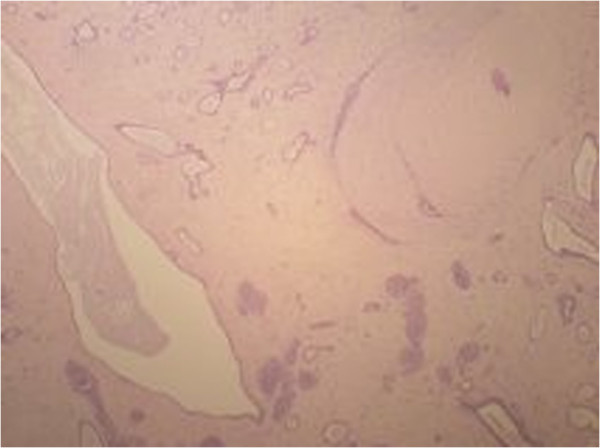

In [3]:
query_path = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC3716517/3716517_1/3716517_1_5.jpg"
Image.open(query_path)

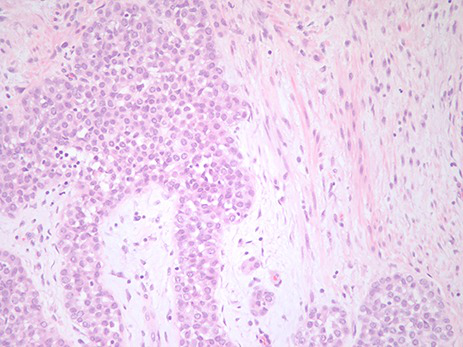

In [7]:
golden_path = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC7136718/7136718_1/7136718_1_1.jpg"
Image.open(golden_path)

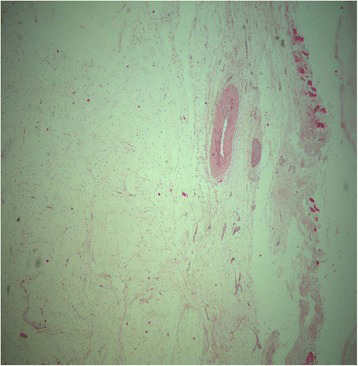

In [18]:
highest_ranked_path = "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4527122/4527122_1/4527122_1_7.jpg"
Image.open(highest_ranked_path)

In [23]:
# query caption
!cat "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC6146114/6146114_1/6146114_1_1.txt"

Transabdominal ultrasonographic image of a tumor measuring 10 cm in diameter showing a homogeneous echo pattern

In [25]:
# golden caption
!cat "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC4339864/4339864_1/4339864_1_1.txt"

Transabdominal ultrasonographic image of the tumor. The mass was 10 cm in diameter, with a high echoic area in the center surrounded by a low echoic area.

In [26]:
# highest rank caption
!cat "/cs/labs/tomhope/yuvalbus/pmc/pythonProject/data2/PMC5912705/5912705_1/5912705_1_5.txt"

Follow up color Doppler ultrasound shows no evidence of blood flow within the pseudoaneurysm.

In [103]:
pair_list = [((query_path, golden_path), 1)]
inference_set = TestImagePairDataset(pair_list, transform=preprocess)
inference_dataloader = DataLoader(inference_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [104]:
for (img1, img2), _ in inference_dataloader:
    img1 = img1.to(device)
    img2 = img2.to(device)
    emb1 = image_embedding_model(img1)
    emb2 = image_embedding_model(img2)
    print(F.cosine_similarity(emb1, emb2))

tensor([0.4873], device='cuda:0', grad_fn=<SumBackward1>)


In [8]:
len(train_data) + len(test_data)

3048

In [9]:
# Save the trained model
torch.save(image_embedding_model, base_path+'/image_embedding_model_full.pth')

In [ ]:
# Reload the trained model
image_embedding_model = torch.load(base_path+'/image_embedding_model_full.pth')
image_embedding_model.to(device)
image_embedding_model.eval()
